In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from pycaret.classification import *
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay

# Heart Failure Prediction Models

This notebook develops and four different classifier models to predict the risk of heart failure based on clinical features.

### Data
The data was obtained from the UR Irvine Machine Learning Repository and consists of 12 clinical featuresacross data for 299 heart feailure patients.

### Models Used:
* Random Forest Classifier
* Naive Bayes
* LGBM Classifier
* Logistic Regression

### Methodology:
* Numerical features scaled using `StandardScaler`.
* Pipelines used for consistent, reproducbile preprocessing within each model.
* Hyperparameters optimized using 5-fold cross-validation.
* ROC curves and confusion matrices  used for model evaluation.

### Evaluation Metrics:
Models were evaluated based on:
* Accuracy, Recall, Precision, F1 score
* AUC
* Confusion Matrix
* ROC Curve

In [2]:
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['axes.grid'] = False

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_failure_clinical_records = fetch_ucirepo(id=519) 
  
# data (as pandas dataframes) 
X = heart_failure_clinical_records.data.features 
y = heart_failure_clinical_records.data.targets 
  
# variable information 
print(heart_failure_clinical_records.variables) 

                        name     role        type demographic  \
0                        age  Feature     Integer         Age   
1                    anaemia  Feature      Binary        None   
2   creatinine_phosphokinase  Feature     Integer        None   
3                   diabetes  Feature      Binary        None   
4          ejection_fraction  Feature     Integer        None   
5        high_blood_pressure  Feature      Binary        None   
6                  platelets  Feature  Continuous        None   
7           serum_creatinine  Feature  Continuous        None   
8               serum_sodium  Feature     Integer        None   
9                        sex  Feature      Binary         Sex   
10                   smoking  Feature      Binary        None   
11                      time  Feature     Integer        None   
12               death_event   Target      Binary        None   

                                          description             units  \
0             

In [4]:
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [6]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10,1
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162,1
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171,1
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112,0
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27,1


In [7]:
clf = setup(data=train_df, target='death_event', session_id=123)
best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,death_event
2,Target type,Binary
3,Original data shape,"(239, 13)"
4,Transformed data shape,"(239, 13)"
5,Transformed train set shape,"(167, 13)"
6,Transformed test set shape,"(72, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9048,0.9470,0.7800,0.8933,0.8259,0.7614,0.7702,0.0170
lightgbm,Light Gradient Boosting Machine,0.8750,0.9302,0.7200,0.8564,0.7644,0.6826,0.6999,0.0290
nb,Naive Bayes,0.8566,0.8447,0.7200,0.8100,0.7534,0.6534,0.6624,0.0040
et,Extra Trees Classifier,0.8562,0.9118,0.6400,0.8517,0.7199,0.6277,0.6455,0.0150
ada,Ada Boost Classifier,0.8441,0.8548,0.6600,0.8371,0.7195,0.6150,0.6360,0.0110
gbc,Gradient Boosting Classifier,0.8379,0.9227,0.6800,0.7988,0.7150,0.6047,0.6220,0.0120
dt,Decision Tree Classifier,0.8331,0.7947,0.7000,0.7760,0.7091,0.5965,0.6189,0.0040
lda,Linear Discriminant Analysis,0.8268,0.8635,0.7200,0.7188,0.7139,0.5909,0.5953,0.0050
ridge,Ridge Classifier,0.8210,0.0000,0.6800,0.7117,0.6917,0.5664,0.5695,0.0040
lr,Logistic Regression,0.8143,0.8652,0.6600,0.7138,0.6794,0.5502,0.5563,0.3900


In [8]:
pprint.pp(best_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [9]:
# Initialize model dict for comparison
model_dict = {}

# Random Forest Classifier

In [10]:
scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_trans, y_train)
y_pred = rfc.predict(X_test_trans)
accuracy_score(y_test, y_pred)

0.75

In [11]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_vars)
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__max_leaf_nodes': [None, 1, 5],
    'classifier__n_jobs': [-1, None]
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

model_dict['Random Forest Classifier'] = grid

print(grid.best_score_)

0.8829787234042554


# LGBM

In [12]:
scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

lgbm = LGBMClassifier(random_state=42, verbose=-1)
lgbm.fit(X_train_trans, y_train)
y_pred = lgbm.predict(X_test_trans)
accuracy_score(y_test, y_pred)

0.75

In [13]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_vars)
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__num_leaves': [15, 31],
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

model_dict['LGBM Classifier'] = grid

print(grid.best_score_)

0.874645390070922


# Naive Bayes

In [14]:
scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

nb = GaussianNB()
nb.fit(X_train_trans, y_train)
y_pred = nb.predict(X_test_trans)
accuracy_score(y_test, y_pred)

0.7

In [15]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_vars)
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

model_dict['Naive Bayes Classifier'] = grid

print(grid.best_score_)

0.7781914893617022


# Logistic Regression

In [16]:
scaler = StandardScaler().fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)
accuracy_score(y_test, y_pred)

0.8

In [17]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_vars)
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear']
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

model_dict['Logistic Regression'] = grid

print(grid.best_score_)

0.8281914893617021


# Evaluation

In [18]:
def score_models(models):
    scores_dict = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        
        scores_dict[name] = {'Accuracy': accuracy_score(y_test, y_pred),
                       'Precision': precision_score(y_test, y_pred),
                       'Recall': recall_score(y_test, y_pred),
                       'F1': f1_score(y_test, y_pred)}
                       
    return scores_dict

In [19]:
scores_dict = score_models(model_dict)
scores_dict

{'Random Forest Classifier': {'Accuracy': 0.7333333333333333,
  'Precision': 0.8,
  'Recall': 0.48,
  'F1': 0.6},
 'LGBM Classifier': {'Accuracy': 0.75,
  'Precision': 0.7272727272727273,
  'Recall': 0.64,
  'F1': 0.6808510638297872},
 'Naive Bayes Classifier': {'Accuracy': 0.7,
  'Precision': 0.8181818181818182,
  'Recall': 0.36,
  'F1': 0.5},
 'Logistic Regression': {'Accuracy': 0.8,
  'Precision': 0.9333333333333333,
  'Recall': 0.56,
  'F1': 0.7}}

In [20]:
scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df = scores_df.T.reset_index(names='Classifier')
scores_df = round(scores_df, 2)
scores_df

,Classifier,Accuracy,Precision,Recall,F1
0,Random Forest Classifier,0.73,0.80,0.48,0.60
1,LGBM Classifier,0.75,0.73,0.64,0.68
2,Naive Bayes Classifier,0.70,0.82,0.36,0.50
3,Logistic Regression,0.80,0.93,0.56,0.70


In [21]:
df_long = scores_df.melt(id_vars='Classifier', 
                  value_vars=['Accuracy', 'Precision', 'Recall', 'F1'],
                  var_name='Metric', value_name='Value')
df_long

,Classifier,Metric,Value
0,Random Forest Classifier,Accuracy,0.73
1,LGBM Classifier,Accuracy,0.75
2,Naive Bayes Classifier,Accuracy,0.70
3,Logistic Regression,Accuracy,0.80
4,Random Forest Classifier,Precision,0.80
5,LGBM Classifier,Precision,0.73
6,Naive Bayes Classifier,Precision,0.82
7,Logistic Regression,Precision,0.93
8,Random Forest Classifier,Recall,0.48
9,LGBM Classifier,Recall,0.64


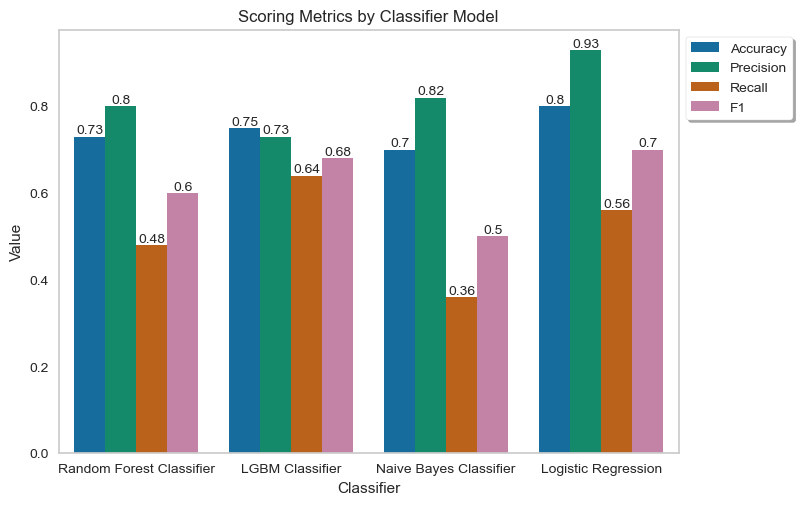

In [22]:
import seaborn as sns

ax = sns.barplot(data=df_long, x='Classifier', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=True, frameon=True)
plt.title('Scoring Metrics by Classifier Model')
plt.show()


## Confusion Matrix

In [23]:
# Create dicts for y_pred and y_proba for each model
y_pred_dict = {}
y_proba_dict = {}

model_names = list(model_dict.keys())

for name, model in model_dict.items():
    y_pred_dict[name] = model.predict(X_test)
    y_proba_dict[name] = model.predict_proba(X_test)[:,1]


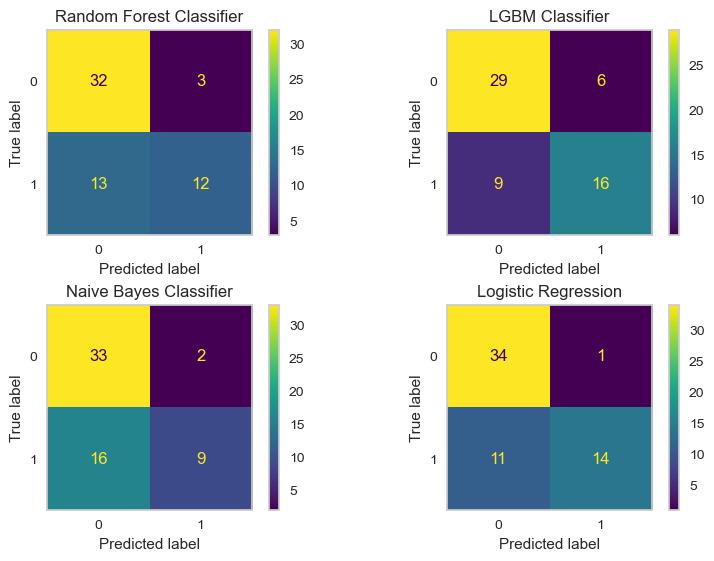

In [24]:
fig, ax = plt.subplots(2, 2, layout='constrained')

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dict[model_names[0]])).plot(ax=ax[0,0])
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dict[model_names[1]])).plot(ax=ax[0,1])
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dict[model_names[2]])).plot(ax=ax[1,0])
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_dict[model_names[3]])).plot(ax=ax[1,1])

ax[0, 0].set_title(model_names[0])
ax[0, 1].set_title(model_names[1])
ax[1, 0].set_title(model_names[2])
ax[1, 1].set_title(model_names[3])

plt.show()

* Random Forest and Naive Bayes have large numbers of false negatives
* Logistic Regression has more false negatives than LGBM, but has fewer (only 1) false positives and a greater total number of correct predictions
* Because this is a death prediction classifier, we want to avoid false negatives and optimize for a better recall score so LGBM may be a better model for this problem than Logisitic Regression, despite it's lower accuracy and precision

# ROC AUC Curve

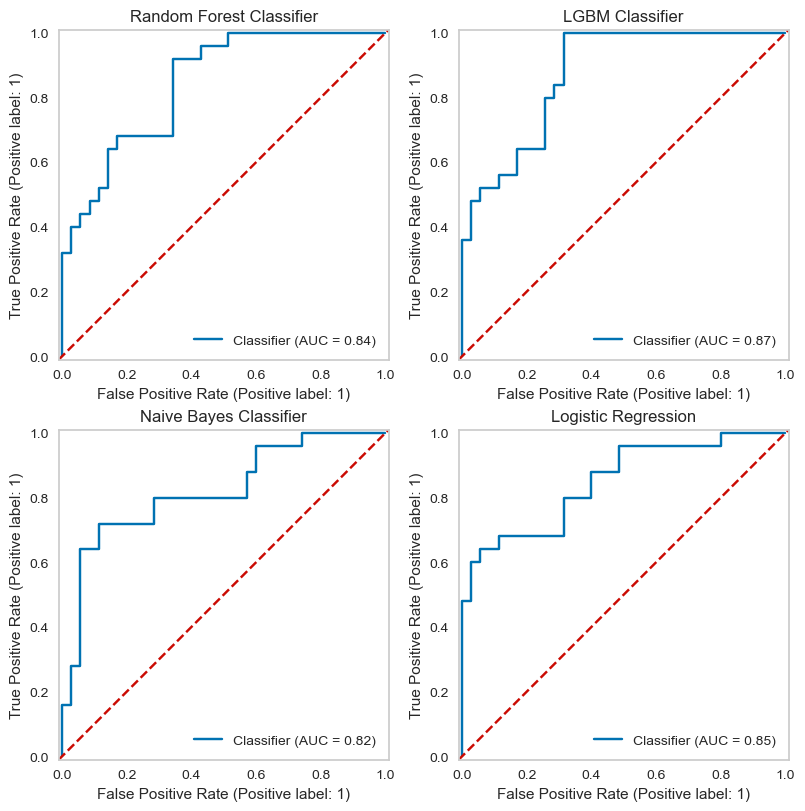

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), layout='constrained')

RocCurveDisplay.from_predictions(y_test, y_proba_dict[model_names[0]], ax=ax[0,0])
RocCurveDisplay.from_predictions(y_test, y_proba_dict[model_names[1]], ax=ax[0,1])
RocCurveDisplay.from_predictions(y_test, y_proba_dict[model_names[2]], ax=ax[1,0])
RocCurveDisplay.from_predictions(y_test, y_proba_dict[model_names[3]], ax=ax[1,1])

ax[0, 0].set_title(model_names[0])
ax[0, 0].axline((0, 0), slope=1, linestyle='--', color='r', label='Random Classifier')
ax[0, 1].set_title(model_names[1])
ax[0, 1].axline((0, 0), slope=1, linestyle='--', color='r', label='Random Classifier')
ax[1, 0].set_title(model_names[2])
ax[1, 0].axline((0, 0), slope=1, linestyle='--', color='r', label='Random Classifier')
ax[1, 1].set_title(model_names[3])
ax[1, 1].axline((0, 0), slope=1, linestyle='--', color='r', label='Random Classifier')


plt.show()

* At the current threshold (0.5), the LGBM has the highest AUC score of 0.87.
* However if the threshold is adjusted, the ROC curve indicates that Random Forest can give us the best recall vs precision trade off.

# Feature Importance
Feature importance from the Random Forest Classifier

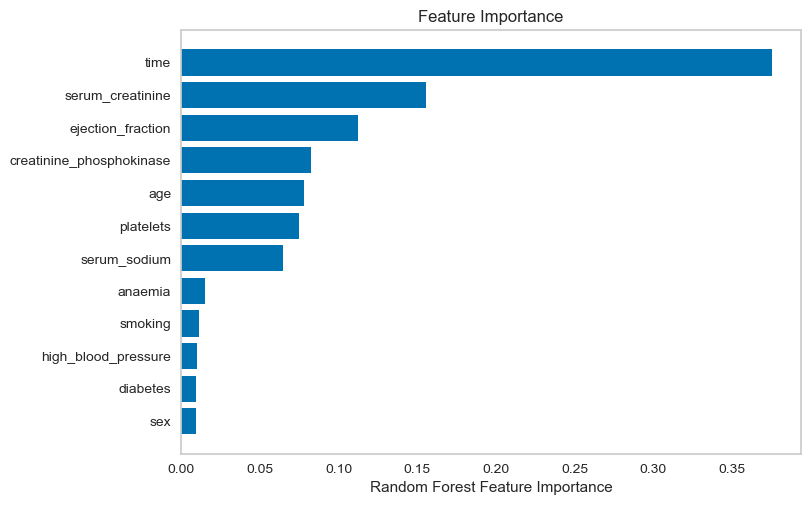

In [26]:
# Code for random forest feature importance graph adapted from https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem

features = X_test.columns.tolist()

plt.figure()
importance = rfc.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[features[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
plt.show()

# Next Steps
* Consider adjusting for class imbalance of death_event
* Threshold optimization based on ROC-AUC curve analysis
* Precision-recall curves for better insight into minority class performance
* Model comparison table
* Explore feature importance further to increase interpretability
* Explore feature reducation/ablation to see if any effect on model performance
* Pickle best-perfoming model after further optimization for future use
